In [40]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymutspec.annotation import calculate_mutspec, CodonAnnotation, mutations_summary
from pymutspec.constants import possible_sbs192, possible_codons ,possible_sbs12
from scipy.spatial.distance import pdist, cdist, squareform, cosine

sns.set_style()

In [2]:
coda = CodonAnnotation(2)

## Load prepared mutations and reference

In [3]:
mutations = pd.read_csv("https://raw.githubusercontent.com/mitoclub/mtdnaMutSpecOfCancers/main/data/processed/mutations.csv")
print(mutations.shape)
mutations.head()

(7611, 17)


,sample,tissue,cancer_type,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,AltCodon,Label,Mut
0,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder,BLCA,200.0,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,NaN,0,T[T>C]G
1,ICGC_0437,Pancreas,PAEN,360.0,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,NaN,0,T[T>C]G
2,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder,BLCA,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,CTC,2,T[T>C]A
3,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder,BLCA,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,ACC,0,T[G>A]C
4,OCCAMS-RS-031,Esophagus,ESAD,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,ACC,0,T[G>A]C


In [4]:
Ref = pd.read_csv("https://raw.githubusercontent.com/mitoclub/mtdnaMutSpecOfCancers/main/data/processed/ref_annot.csv")
print(Ref.shape)
Ref.head()

(16569, 10)


,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS
0,1,G,NaN,-1,D-loop,NaN,-1,-1,NaN,NaN
1,2,A,GAT,-1,D-loop,NaN,-1,-1,NaN,NaN
2,3,T,ATC,-1,D-loop,NaN,-1,-1,NaN,NaN
3,4,C,TCA,-1,D-loop,NaN,-1,-1,NaN,NaN
4,5,A,CAC,-1,D-loop,NaN,-1,-1,NaN,NaN


In [5]:
obs_all = mutations[
    (mutations.Type != "D-loop") &
    (mutations.Label >= 0)
]
print(obs_all.shape)
obs_all.head()

(6340, 17)


,sample,tissue,cancer_type,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,AltCodon,Label,Mut
0,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder,BLCA,200.0,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,NaN,0,T[T>C]G
1,ICGC_0437,Pancreas,PAEN,360.0,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,NaN,0,T[T>C]G
2,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder,BLCA,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,CTC,2,T[T>C]A
3,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder,BLCA,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,ACC,0,T[G>A]C
4,OCCAMS-RS-031,Esophagus,ESAD,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,ACC,0,T[G>A]C


## Generage patient-specific spectra samples

In [12]:
obs_all['sbs12'] = obs_all['Mut'].str.slice(2,5)

In [20]:
nuc_counts_all = Ref[Ref.Type != 'D-loop'].Nuc.value_counts().to_dict()
nuc_counts_all

{'C': 4810, 'A': 4785, 'T': 3834, 'G': 2017}

In [43]:
patient_obs = obs_all.groupby(['tissue', 'sample']).sbs12.value_counts().unstack().fillna(0.)
patient_spectra = patient_obs.copy()
patient_spectra['nobs'] = patient_obs.sum(1)

for x in possible_sbs12:
    patient_spectra[x] /= nuc_counts_all[x[0]]

patient_spectra

sbs12                                         A>C       A>G  A>T  C>A  C>G  \
tissue  sample                                                               
Biliary BTCA_donor_27                         0.0  0.000000  0.0  0.0  0.0   
        BTCA_donor_A035                       0.0  0.000000  0.0  0.0  0.0   
        BTCA_donor_A096                       0.0  0.000000  0.0  0.0  0.0   
        BTCA_donor_A153                       0.0  0.000000  0.0  0.0  0.0   
        BTCA_donor_B070                       0.0  0.000000  0.0  0.0  0.0   
...                                           ...       ...  ...  ...  ...   
Uterus  f6d136c7-c250-4361-9fed-50f513959a40  0.0  0.000000  0.0  0.0  0.0   
        f7e06a10-74ca-4f52-a944-b3f22c016998  0.0  0.000000  0.0  0.0  0.0   
        f8ac5fd2-11f2-4b3a-a3a6-ff1a6d8e1cae  0.0  0.000209  0.0  0.0  0.0   
        fba80122-d8b2-4d8d-a032-9767e8160f9f  0.0  0.000000  0.0  0.0  0.0   
        ffaa98a0-2b69-46dc-aee5-c5c3f2abbc38  0.0  0.000000  0.0  0.0  0.0   

sbs12                                              C>T       G>A       G>C  \
tissue  sample                                                               
Biliary BTCA_donor_27                         0.000208  0.000496  0.000000   
        BTCA_donor_A035                       0.000000  0.000000  0.000000   
        BTCA_donor_A096                       0.000000  0.000496  0.000000   
        BTCA_donor_A153                       0.000208  0.000000  0.000000   
        BTCA_donor_B070                       0.000000  0.000496  0.000496   
...                                                ...       ...       ...   
Uterus  f6d136c7-c250-4361-9fed-50f513959a40  0.000000  0.000496  0.000000   
        f7e06a10-74ca-4f52-a944-b3f22c016998  0.000208  0.000496  0.000000   
        f8ac5fd2-11f2-4b3a-a3a6-ff1a6d8e1cae  0.000000  0.000992  0.000000   
        fba80122-d8b2-4d8d-a032-9767e8160f9f  0.000208  0.001487  0.000000   
        ffaa98a0-2b69-46dc-aee5-c5c3f2abbc38  0.000000  0.000496  0.000000   

sbs12                                         G>T  T>A       T>C  T>G  nobs  
tissue  sample                                                               
Biliary BTCA_donor_27                         0.0  0.0  0.000000  0.0   2.0  
        BTCA_donor_A035                       0.0  0.0  0.000261  0.0   1.0  
        BTCA_donor_A096                       0.0  0.0  0.000522  0.0   3.0  
        BTCA_donor_A153                       0.0  0.0  0.000000  0.0   1.0  
        BTCA_donor_B070                       0.0  0.0  0.000000  0.0   2.0  
...                                           ...  ...       ...  ...   ...  
Uterus  f6d136c7-c250-4361-9fed-50f513959a40  0.0  0.0  0.000000  0.0   1.0  
        f7e06a10-74ca-4f52-a944-b3f22c016998  0.0  0.0  0.000000  0.0   2.0  
        f8ac5fd2-11f2-4b3a-a3a6-ff1a6d8e1cae  0.0  0.0  0.000261  0.0   4.0  
        fba80122-d8b2-4d8d-a032-9767e8160f9f  0.0  0.0  0.000782  0.0   7.0  
        ffaa98a0-2b69-46dc-aee5-c5c3f2abbc38  0.0  0.0  0.000261  0.0   2.0  

[2088 rows x 13 columns]

In [102]:
patient_spectra.index.to_frame().tissue.value_counts()

Liver              288
Pancreas           248
Breast             191
Prostate           186
Kidney             177
Lymphoid           138
CNS                129
Ovary              100
Esophagus           91
Skin                83
Lung                78
Bone/SoftTissue     60
Stomach             58
Colon/Rectum        53
Head/Neck           46
Thyroid             41
Uterus              40
Biliary             29
Myeloid             23
Bladder             18
Cervix              11
Name: tissue, dtype: int64

In [44]:
patient_spectra_mean = patient_spectra.sum().rename('MutSpec').reset_index()
patient_spectra_mean

,sbs12,MutSpec
0,A>C,0.016719
1,A>G,0.072727
2,A>T,0.013584
3,C>A,0.024324
4,C>G,0.003326
5,C>T,0.096466
6,G>A,1.584531
7,G>C,0.055528
8,G>T,0.013882
9,T>A,0.005738


In [25]:
ts = ['C>T', 'T>C', 'G>A', 'A>G']

### frac=0.5

In [103]:
nsamples = 100
d = []
for t in patient_spectra.index.get_level_values(0).unique():
    for i in range(nsamples):
        patient_spectra_mean = patient_spectra.loc[t].sample(frac=0.5, replace=False)\
            .sum().rename('MutSpec').reset_index().assign(sample=i, tissue=t)
        d.append(patient_spectra_mean)

samples = pd.concat(d, ignore_index=True)
samples_wide = samples.pivot(['tissue', 'sample'], 'sbs12', 'MutSpec')[possible_sbs12]
samples_wide.head()

sbs12           A>C       A>G       A>T       C>A  C>G       C>T       G>A  \
tissue  sample                                                               
Biliary 0       0.0  0.000000  0.000209  0.000000  0.0  0.000208  0.010907   
        1       0.0  0.000418  0.000209  0.000208  0.0  0.000832  0.009420   
        2       0.0  0.000418  0.000000  0.000000  0.0  0.001040  0.007933   
        3       0.0  0.000000  0.000209  0.000208  0.0  0.001247  0.007933   
        4       0.0  0.000418  0.000209  0.000208  0.0  0.001247  0.010412   

sbs12                G>C  G>T  T>A       T>C  T>G  
tissue  sample                                     
Biliary 0       0.000992  0.0  0.0  0.003652  0.0  
        1       0.000496  0.0  0.0  0.002608  0.0  
        2       0.000000  0.0  0.0  0.003912  0.0  
        3       0.000000  0.0  0.0  0.001043  0.0  
        4       0.000496  0.0  0.0  0.002087  0.0

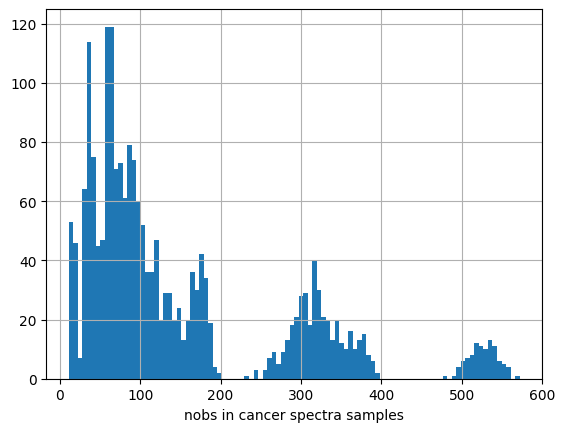

In [104]:
samples[samples.sbs12 == 'nobs'].MutSpec.hist(bins=100)\
    .set_xlabel('nobs in cancer spectra samples');

In [105]:
cossim_samp_vs_samp = 1-pdist(samples_wide, 'cosine')
print('cossim_samp_vs_samp', np.quantile(cossim_samp_vs_samp,   [0., .25, .5, .75, 1.]).round(2))


cossim_samp_vs_samp [0.8  0.98 0.99 1.   1.  ]


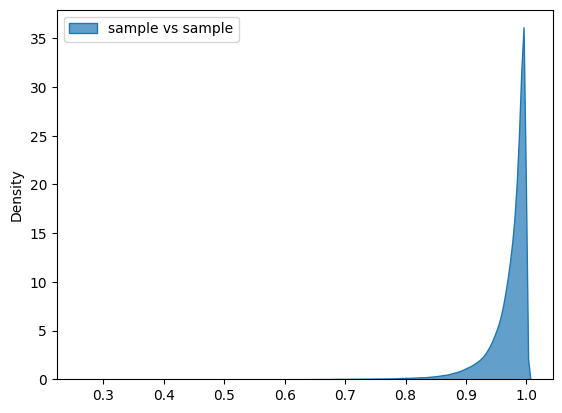

In [55]:
sns.kdeplot(cossim_samp_vs_samp, label='sample vs sample', fill=True, alpha=0.7)
plt.legend(loc='upper left')
plt.show()

In [106]:
import umap

full_data = samples_wide
print('input data shape:', full_data.shape)

# Standardize the data
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(full_data)
scaled_data = (full_data.T / full_data.sum(axis=1)).T

# Create UMAP instance and fit the data
umap_instance = umap.UMAP(n_neighbors=5, n_components=2, metric='cosine',  random_state=777)#, learning_rate=2., n_epochs=100000)
umap_result = umap_instance.fit_transform(scaled_data)

# Create a new dataframe with the UMAP results
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])
umap_df['tissue'] = full_data.index.get_level_values(0)
print(umap_df.shape)
umap_df.head()

input data shape: (2100, 12)
(2100, 3)


,UMAP1,UMAP2,tissue
0,6.693699,4.291735,Biliary
1,12.048236,1.943831,Biliary
2,3.839474,5.252157,Biliary
3,18.846823,3.140105,Biliary
4,17.648746,4.167483,Biliary


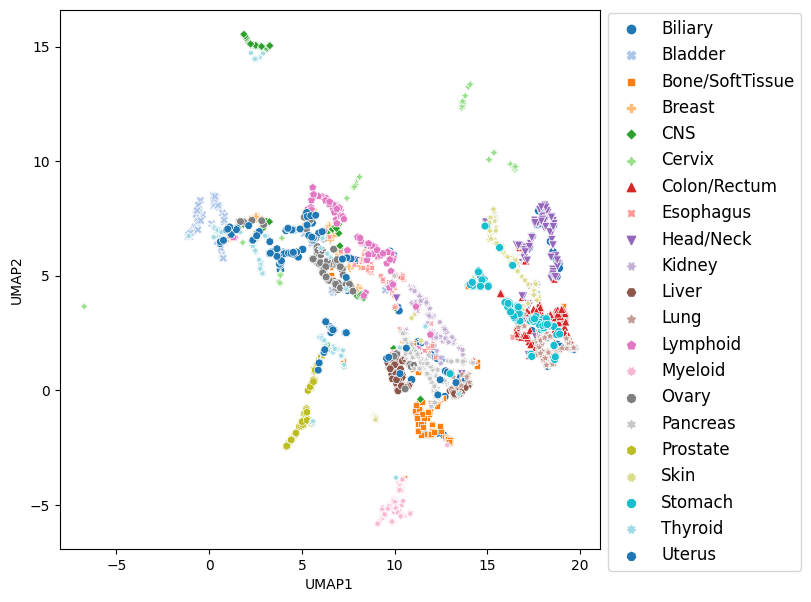

In [107]:
plt.figure(figsize=(8,7))
ax = sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='tissue',
                     style='tissue', palette='tab20')

# Move the legend outside of the plot to the right
legend = ax.legend(bbox_to_anchor=(1, 1.01), loc='upper left', fontsize=12)
plt.subplots_adjust(right=0.8)  # Adjust the right margin to make space for the legend
# plt.savefig('../pictures/human_cancer_spectra_syn_samples_umap.pdf', bbox_inches='tight')
plt.show()

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a new dataframe with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Get the variance share of each principal component
variance_ratio = pca.explained_variance_ratio_
variance_share_pc1 = round(variance_ratio[0]*100, 2)
variance_share_pc2 = round(variance_ratio[1]*100, 2)

pca_df['tissue'] = full_data.index.get_level_values(0)

pca_df.head()

,PC1,PC2,tissue
0,0.018773,0.054603,Biliary
1,0.028373,-0.013487,Biliary
2,-0.085692,0.022417,Biliary
3,0.151633,-0.053448,Biliary
4,0.077358,-0.043562,Biliary


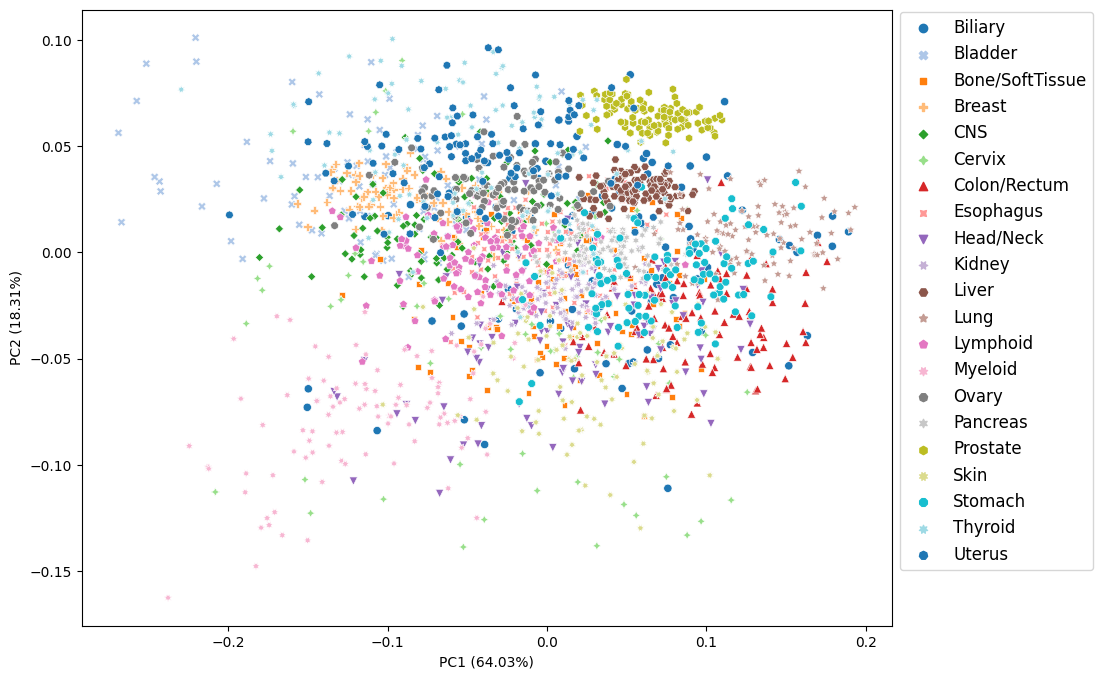

In [109]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='tissue', style='tissue', palette='tab20')
# ax.set_xlim(-10.5, 8)
ax.set_xlabel(f'PC1 ({variance_share_pc1}%)')
ax.set_ylabel(f'PC2 ({variance_share_pc2}%)')

# Move the legend outside of the plot to the right
legend = ax.legend(bbox_to_anchor=(1, 1.01), loc='upper left', fontsize=12)
plt.subplots_adjust(right=0.8)  # Adjust the right margin to make space for the legend

plt.show()

In [110]:
t_sim = pd.DataFrame(1 - squareform(pdist(samples_wide, "cosine")), 
                        index=samples_wide.index, 
                        columns=samples_wide.index)
t_sim

tissue           Biliary                                                    \
sample                0         1         2         3         4         5    
tissue  sample                                                               
Biliary 0       1.000000  0.994637  0.981174  0.968554  0.985679  0.991213   
        1       0.994637  1.000000  0.980370  0.985866  0.996896  0.998480   
        2       0.981174  0.980370  1.000000  0.945489  0.965375  0.971134   
        3       0.968554  0.985866  0.945489  1.000000  0.995222  0.991666   
        4       0.985679  0.996896  0.965375  0.995222  1.000000  0.999091   
...                  ...       ...       ...       ...       ...       ...   
Uterus  95      0.990850  0.986437  0.994307  0.951409  0.971542  0.977116   
        96      0.993284  0.998346  0.975082  0.985182  0.995525  0.996366   
        97      0.983698  0.980903  0.998096  0.942145  0.964438  0.970330   
        98      0.991336  0.984971  0.994193  0.949929  0.969635  0.976069   
        99      0.996729  0.996456  0.986907  0.975351  0.988675  0.992048   

tissue                                                  ...    Uterus  \
sample                6         7         8         9   ...        90   
tissue  sample                                          ...             
Biliary 0       0.991379  0.993162  0.979899  0.992288  ...  0.985000   
        1       0.998719  0.995842  0.988790  0.997511  ...  0.980813   
        2       0.972585  0.973214  0.943649  0.987847  ...  0.998494   
        3       0.990019  0.985087  0.993861  0.982942  ...  0.944078   
        4       0.998725  0.992956  0.995149  0.992669  ...  0.964587   
...                  ...       ...       ...       ...  ...       ...   
Uterus  95      0.979295  0.985460  0.957451  0.991188  ...  0.997512   
        96      0.997745  0.998072  0.990742  0.996077  ...  0.977521   
        97      0.972737  0.975590  0.944555  0.987054  ...  0.999074   
        98      0.977765  0.985203  0.956540  0.990550  ...  0.997578   
        99      0.992603  0.995571  0.979961  0.997751  ...  0.989660   

tissue                                                                      \
sample                91        92        93        94        95        96   
tissue  sample                                                               
Biliary 0       0.991196  0.981254  0.996249  0.995320  0.990850  0.993284   
        1       0.993189  0.972513  0.997998  0.998036  0.986437  0.998346   
        2       0.994373  0.995786  0.983770  0.988720  0.994307  0.975082   
        3       0.966905  0.927607  0.981446  0.977990  0.951409  0.985182   
        4       0.983098  0.952606  0.992686  0.991524  0.971542  0.995525   
...                  ...       ...       ...       ...       ...       ...   
Uterus  95      0.997199  0.994474  0.991469  0.993418  1.000000  0.986138   
        96      0.991921  0.968117  0.997947  0.996820  0.986138  1.000000   
        97      0.996160  0.996252  0.985188  0.989603  0.997625  0.978165   
        98      0.995629  0.995007  0.990863  0.992286  0.999351  0.984034   
        99      0.995689  0.984589  0.998637  0.997851  0.994213  0.995881   

tissue                                        
sample                97        98        99  
tissue  sample                                
Biliary 0       0.983698  0.991336  0.996729  
        1       0.980903  0.984971  0.996456  
        2       0.998096  0.994193  0.986907  
        3       0.942145  0.949929  0.975351  
        4       0.964438  0.969635  0.988675  
...                  ...       ...       ...  
Uterus  95      0.997625  0.999351  0.994213  
        96      0.978165  0.984034  0.995881  
        97      1.000000  0.996526  0.988077  
        98      0.996526  1.000000  0.993855  
        99      0.988077  0.993855  1.000000  

[2100 rows x 2100 columns]

In [114]:
from itertools import combinations_with_replacement

mean_tis_similarity = []
for t1, t2 in combinations_with_replacement(samples_wide.index.get_level_values(0).unique(), 2):
    cs = t_sim.loc[t1, t2].values.flatten().mean()
    mean_tis_similarity.append((t1, t2, cs))
    if t1 != t2:
        mean_tis_similarity.append((t2, t1, cs))
mean_tis_similarity = pd.DataFrame(mean_tis_similarity, columns=['tissue1', 'tissue2', 'cossim'])
mean_tis_similarity = mean_tis_similarity.pivot('tissue1', 'tissue2', 'cossim').T

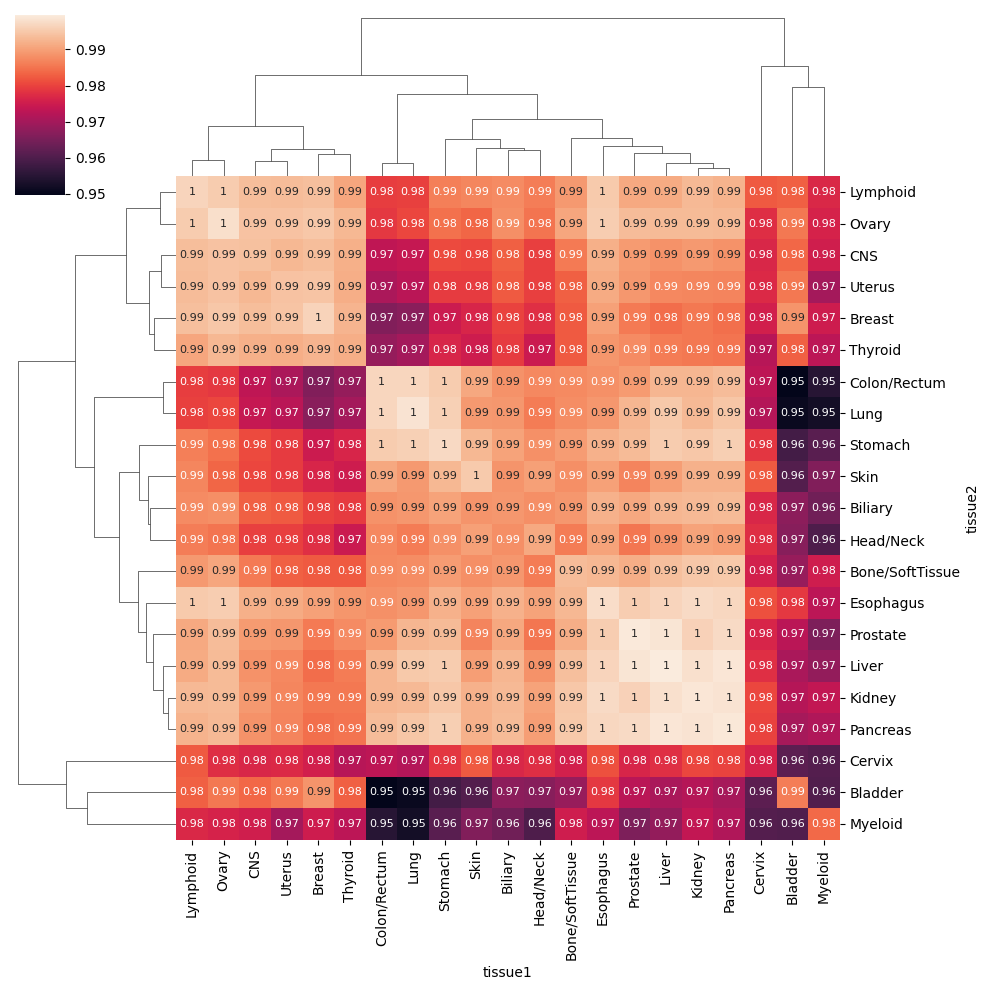

In [118]:
sns.clustermap(mean_tis_similarity, annot=True, annot_kws={'fontsize': 8})

### frac=0.25

In [119]:
nsamples = 100
d = []
for t in patient_spectra.index.get_level_values(0).unique():
    for i in range(nsamples):
        patient_spectra_mean = patient_spectra.loc[t].sample(frac=0.25, replace=False)\
            .sum().rename('MutSpec').reset_index().assign(sample=i, tissue=t)
        d.append(patient_spectra_mean)

samples = pd.concat(d, ignore_index=True)
samples_wide = samples.pivot(['tissue', 'sample'], 'sbs12', 'MutSpec')[possible_sbs12]
samples_wide.head()

sbs12           A>C       A>G  A>T       C>A  C>G       C>T       G>A  \
tissue  sample                                                          
Biliary 0       0.0  0.000000  0.0  0.000000  0.0  0.000000  0.006941   
        1       0.0  0.000000  0.0  0.000000  0.0  0.000416  0.001983   
        2       0.0  0.000418  0.0  0.000000  0.0  0.000624  0.003471   
        3       0.0  0.000209  0.0  0.000000  0.0  0.001040  0.002975   
        4       0.0  0.000000  0.0  0.000208  0.0  0.000416  0.004958   

sbs12                G>C  G>T  T>A       T>C  T>G  
tissue  sample                                     
Biliary 0       0.000496  0.0  0.0  0.001043  0.0  
        1       0.000000  0.0  0.0  0.001043  0.0  
        2       0.000000  0.0  0.0  0.001565  0.0  
        3       0.000000  0.0  0.0  0.001043  0.0  
        4       0.000496  0.0  0.0  0.001043  0.0

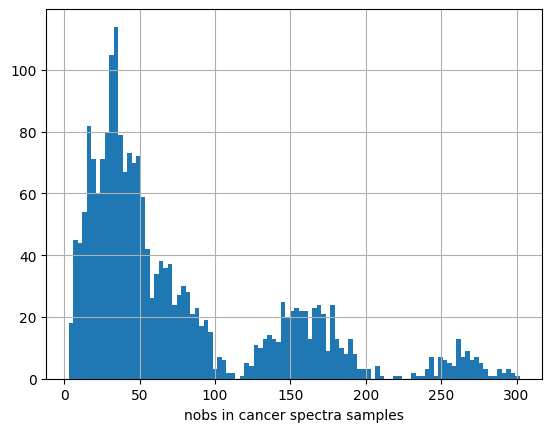

In [120]:
samples[samples.sbs12 == 'nobs'].MutSpec.hist(bins=100)\
    .set_xlabel('nobs in cancer spectra samples');

In [121]:
cossim_samp_vs_samp = 1-pdist(samples_wide, 'cosine')
print('cossim_samp_vs_samp', np.quantile(cossim_samp_vs_samp,   [0., .25, .5, .75, 1.]).round(2))


cossim_samp_vs_samp [0.06 0.96 0.98 0.99 1.  ]


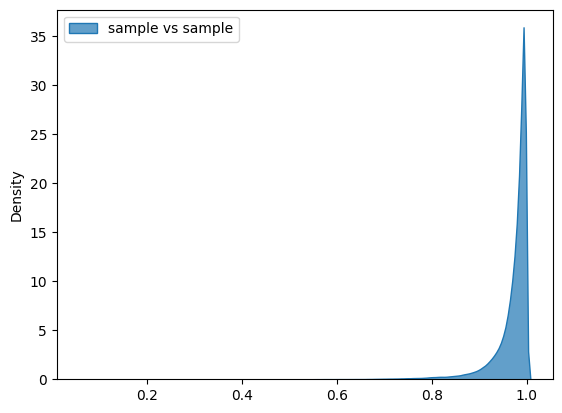

In [122]:
sns.kdeplot(cossim_samp_vs_samp, label='sample vs sample', fill=True, alpha=0.7)
plt.legend(loc='upper left')
plt.show()

In [123]:
import umap

full_data = samples_wide
print('input data shape:', full_data.shape)

# Standardize the data
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(full_data)
scaled_data = (full_data.T / full_data.sum(axis=1)).T

# Create UMAP instance and fit the data
umap_instance = umap.UMAP(n_neighbors=5, n_components=2, metric='cosine',  random_state=777)#, learning_rate=2., n_epochs=100000)
umap_result = umap_instance.fit_transform(scaled_data)

# Create a new dataframe with the UMAP results
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])
umap_df['tissue'] = full_data.index.get_level_values(0)
print(umap_df.shape)
umap_df.head()

input data shape: (2100, 12)
(2100, 3)


,UMAP1,UMAP2,tissue
0,10.242666,-4.641177,Biliary
1,12.344254,9.982632,Biliary
2,7.450963,8.796563,Biliary
3,6.692177,9.185993,Biliary
4,7.025538,-0.767832,Biliary


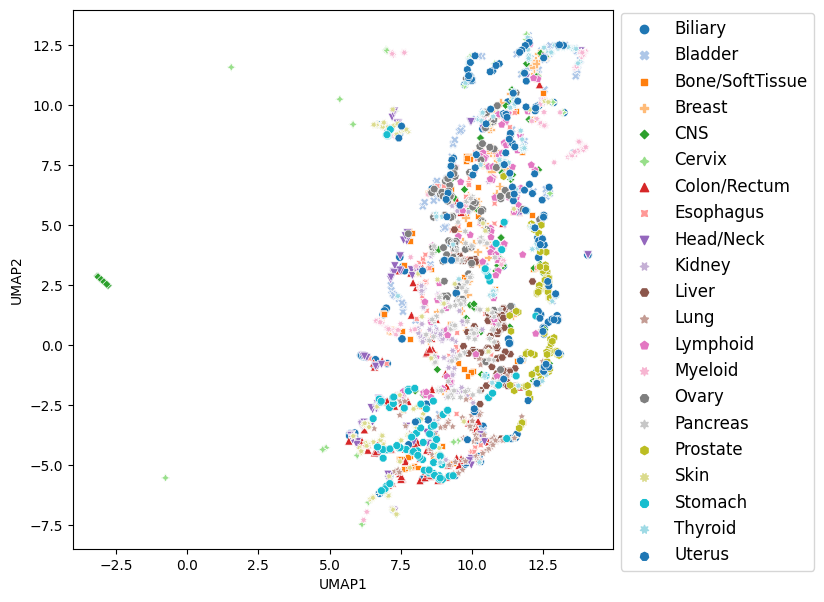

In [124]:
plt.figure(figsize=(8,7))
ax = sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='tissue',
                     style='tissue', palette='tab20')

# Move the legend outside of the plot to the right
legend = ax.legend(bbox_to_anchor=(1, 1.01), loc='upper left', fontsize=12)
plt.subplots_adjust(right=0.8)  # Adjust the right margin to make space for the legend
# plt.savefig('../pictures/human_cancer_spectra_syn_samples_umap.pdf', bbox_inches='tight')
plt.show()

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a new dataframe with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Get the variance share of each principal component
variance_ratio = pca.explained_variance_ratio_
variance_share_pc1 = round(variance_ratio[0]*100, 2)
variance_share_pc2 = round(variance_ratio[1]*100, 2)

pca_df['tissue'] = full_data.index.get_level_values(0)

pca_df.head()

,PC1,PC2,tissue
0,0.196456,0.044604,Biliary
1,-0.104201,0.000601,Biliary
2,-0.090173,-0.031784,Biliary
3,-0.061875,-0.126159,Biliary
4,0.080346,-0.025345,Biliary


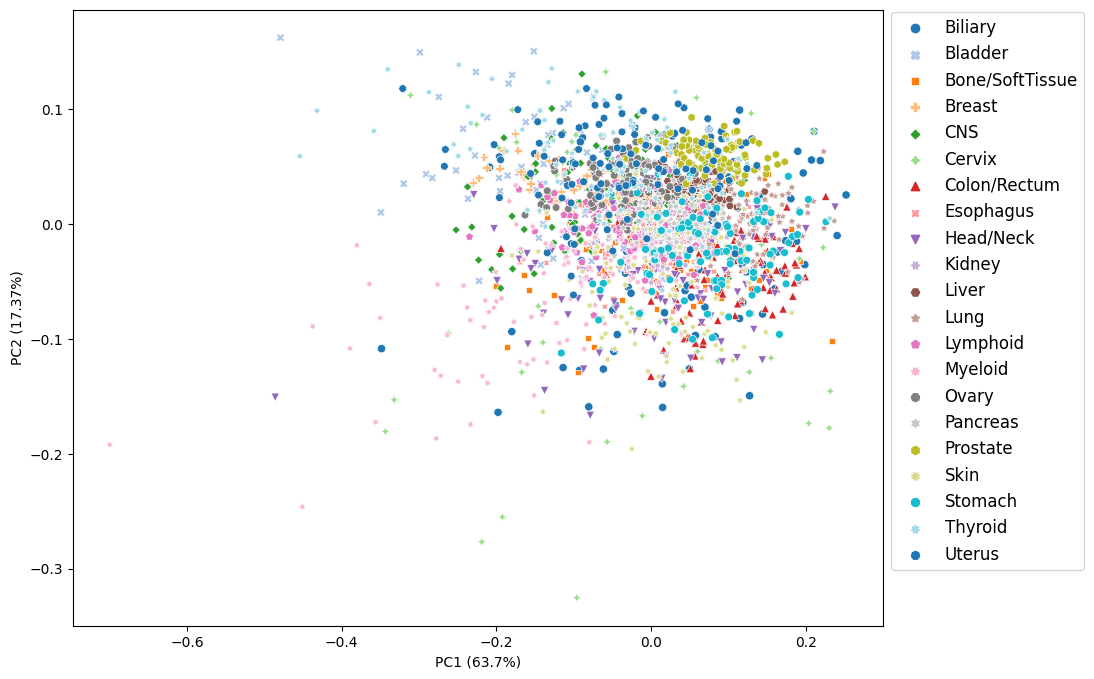

In [126]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='tissue', style='tissue', palette='tab20')
# ax.set_xlim(-10.5, 8)
ax.set_xlabel(f'PC1 ({variance_share_pc1}%)')
ax.set_ylabel(f'PC2 ({variance_share_pc2}%)')

# Move the legend outside of the plot to the right
legend = ax.legend(bbox_to_anchor=(1, 1.01), loc='upper left', fontsize=12)
plt.subplots_adjust(right=0.8)  # Adjust the right margin to make space for the legend

plt.show()

In [127]:
t_sim = pd.DataFrame(1 - squareform(pdist(samples_wide, "cosine")), 
                        index=samples_wide.index, 
                        columns=samples_wide.index)
t_sim

tissue           Biliary                                                    \
sample                0         1         2         3         4         5    
tissue  sample                                                               
Biliary 0       1.000000  0.926219  0.942042  0.928785  0.993818  0.986869   
        1       0.926219  1.000000  0.992186  0.978888  0.952210  0.951283   
        2       0.942042  0.992186  1.000000  0.983454  0.962825  0.962630   
        3       0.928785  0.978888  0.983454  1.000000  0.956914  0.968026   
        4       0.993818  0.952210  0.962825  0.956914  1.000000  0.991358   
...                  ...       ...       ...       ...       ...       ...   
Uterus  95      0.959111  0.985284  0.987341  0.953483  0.969178  0.961492   
        96      0.973009  0.978769  0.986040  0.954780  0.981598  0.969693   
        97      0.995663  0.943572  0.958934  0.952933  0.997906  0.993602   
        98      0.889029  0.984941  0.975252  0.939870  0.918917  0.901517   
        99      0.979439  0.976152  0.982887  0.955617  0.984081  0.978908   

tissue                                                  ...    Uterus  \
sample                6         7         8         9   ...        90   
tissue  sample                                          ...             
Biliary 0       0.976712  0.721820  0.998030  0.993179  ...  0.906433   
        1       0.978895  0.902438  0.903700  0.952093  ...  0.982870   
        2       0.982357  0.904470  0.923011  0.966992  ...  0.972976   
        3       0.956344  0.873187  0.915241  0.944524  ...  0.930648   
        4       0.982723  0.770024  0.988651  0.990065  ...  0.928991   
...                  ...       ...       ...       ...  ...       ...   
Uterus  95      0.996028  0.862822  0.939735  0.981451  ...  0.985281   
        96      0.996293  0.848534  0.957190  0.988057  ...  0.975030   
        97      0.980456  0.757419  0.992013  0.992903  ...  0.919655   
        98      0.957468  0.928997  0.860493  0.920118  ...  0.988616   
        99      0.999187  0.827541  0.965157  0.994391  ...  0.969394   

tissue                                                                      \
sample                91        92        93        94        95        96   
tissue  sample                                                               
Biliary 0       0.976084  0.979491  0.952640  0.938427  0.959111  0.973009   
        1       0.974818  0.979682  0.993611  0.979457  0.985284  0.978769   
        2       0.978567  0.986164  0.993134  0.982225  0.987341  0.986040   
        3       0.947408  0.972313  0.968127  0.937909  0.953483  0.954780   
        4       0.979999  0.990785  0.968335  0.952231  0.969178  0.981598   
...                  ...       ...       ...       ...       ...       ...   
Uterus  95      0.996298  0.988521  0.997749  0.994928  1.000000  0.996574   
        96      0.996353  0.994022  0.993659  0.990204  0.996574  1.000000   
        97      0.977909  0.986771  0.963490  0.947586  0.965708  0.977177   
        98      0.956259  0.956005  0.979632  0.979357  0.974375  0.968155   
        99      0.999078  0.993860  0.992539  0.986325  0.995883  0.997218   

tissue                                        
sample                97        98        99  
tissue  sample                                
Biliary 0       0.995663  0.889029  0.979439  
        1       0.943572  0.984941  0.976152  
        2       0.958934  0.975252  0.982887  
        3       0.952933  0.939870  0.955617  
        4       0.997906  0.918917  0.984081  
...                  ...       ...       ...  
Uterus  95      0.965708  0.974375  0.995883  
        96      0.977177  0.968155  0.997218  
        97      1.000000  0.904065  0.982830  
        98      0.904065  1.000000  0.954648  
        99      0.982830  0.954648  1.000000  

[2100 rows x 2100 columns]

In [128]:
from itertools import combinations_with_replacement

mean_tis_similarity = []
for t1, t2 in combinations_with_replacement(samples_wide.index.get_level_values(0).unique(), 2):
    cs = t_sim.loc[t1, t2].values.flatten().mean()
    mean_tis_similarity.append((t1, t2, cs))
    if t1 != t2:
        mean_tis_similarity.append((t2, t1, cs))
mean_tis_similarity = pd.DataFrame(mean_tis_similarity, columns=['tissue1', 'tissue2', 'cossim'])
mean_tis_similarity = mean_tis_similarity.pivot('tissue1', 'tissue2', 'cossim').T

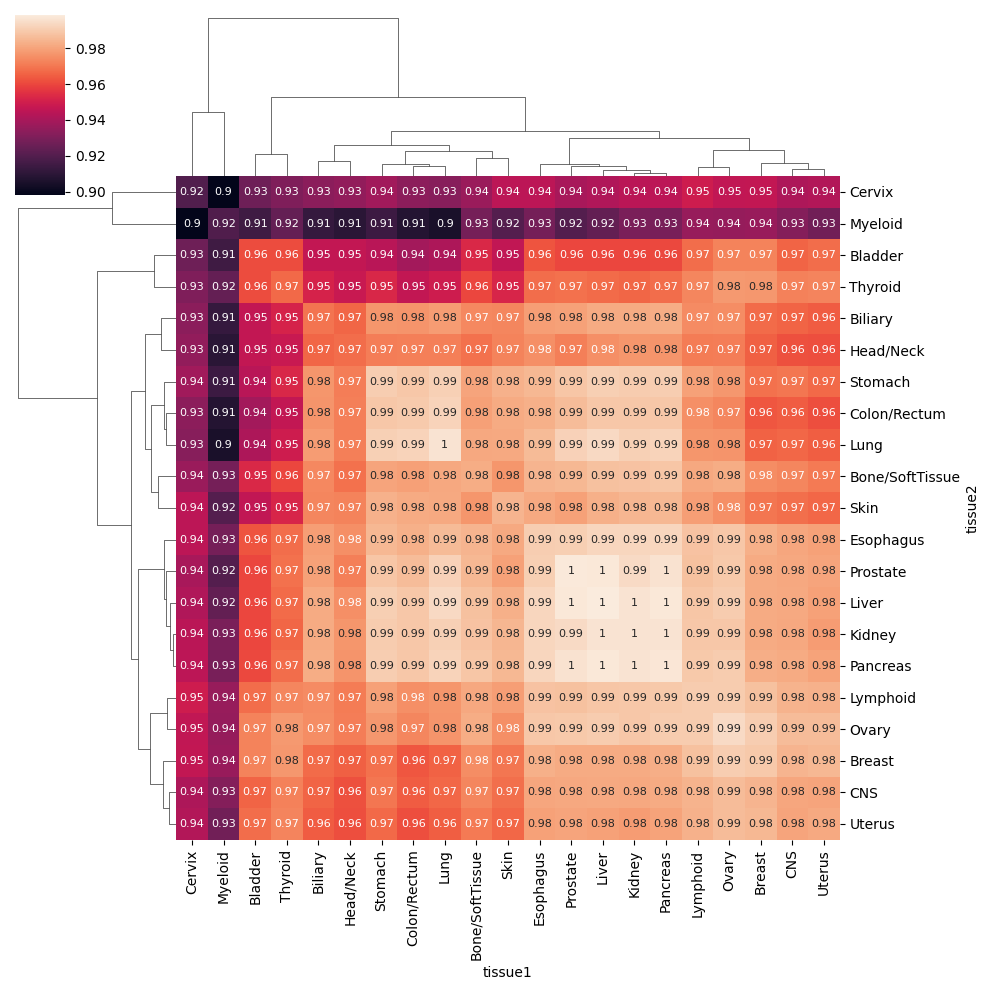

In [129]:
sns.clustermap(mean_tis_similarity, annot=True, annot_kws={'fontsize': 8})